In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import re
import os
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix, 
    precision_score, recall_score, f1_score, log_loss, brier_score_loss, classification_report
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


# Settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("✅ Libraries Loaded.")

✅ Libraries Loaded.


In [211]:
df_model = pd.read_csv("../data/processed/Model_Training.csv")
print(f"Processed Features Shape: {df_model.shape}")

# We need these for the OOT split and the Profit Calculation.
raw_df = pd.read_csv("../data/raw/dataproject2025.csv")

# 1.3 Recover columns based on Index alignment
df_model['issue_d'] = raw_df['issue_d']
df_model.head()

Processed Features Shape: (1086236, 42)


,loan duration,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_tl,num_il_tl,num_rev_accts,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,target,tax_liens,annual_inc_log,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,emp_length_num,issue_d
0,0,1379.0,21564.0,16.1,0.0,2.49,759.0,4800.0,2.0,10.99,220.0,25.0,25.0,0.0,25.0,2.0,4.0,1.0,7.0,3.0,0.0,0.0,4136.0,16.1,0,0.0,10.586610,False,False,False,False,True,False,False,False,False,False,False,False,False,False,2,2013
1,0,9570.0,16473.0,53.9,0.0,22.87,734.0,27050.0,0.0,10.99,326.0,16.0,6.0,4.0,16.0,2.0,8.0,8.0,15.0,14.0,0.0,0.0,36638.0,61.2,0,0.0,10.915107,True,False,False,True,False,False,False,False,False,False,False,False,False,False,10,2013
2,0,53306.0,13901.0,67.1,0.0,18.55,749.0,28000.0,1.0,7.62,229.0,5.0,2.0,5.0,5.0,4.0,8.0,11.0,15.0,15.0,0.0,0.0,29581.0,54.6,0,0.0,12.691584,False,False,False,True,False,False,False,False,False,False,False,False,False,False,5,2013
3,0,36362.0,3567.0,93.0,0.0,13.03,719.0,12000.0,1.0,11.99,193.0,4.0,4.0,3.0,85.0,3.0,4.0,8.0,8.0,9.0,0.0,0.0,10805.0,67.0,0,0.0,11.775297,False,False,False,True,False,False,False,False,False,False,False,False,False,False,10,2013
4,1,24161.0,4853.0,74.7,1.0,23.13,669.0,27600.0,1.0,19.97,294.0,4.0,4.0,4.0,4.0,5.0,11.0,4.0,16.0,10.0,0.0,0.0,27003.0,82.8,1,0.0,11.198228,False,False,False,True,False,False,False,False,False,False,False,False,False,False,6,2013


### 1. Data Splitting

In [228]:
os.makedirs('../data/processed', exist_ok=True)
OOT_TEST_YEAR = 2018 
target_col = 'target'
cols_to_exclude = ['target', 'issue_d']

print(f"✂️  Step 1: Time-based Split (OOT Year: {OOT_TEST_YEAR})...")

# Splitting Train and Test sets based on issue_d 
train_df_raw = df_model[df_model['issue_d'] < OOT_TEST_YEAR].copy()
test_df = df_model[df_model['issue_d'] == OOT_TEST_YEAR].copy()

# Features and Target sepparation function
def get_x_y(df):
    X = df.drop(columns=[c for c in cols_to_exclude if c in df.columns])
    y = df[target_col]
    return X, y

X_train_full, y_train_full = get_x_y(train_df_raw)
X_test, y_test = get_x_y(test_df)

# Train and Validation(Calibration) Split
print(f"🔧 Step 2: Sub-splitting Training set into Base and Calibration...")

X_train_base, X_val_cal, y_train_base, y_val_cal = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.20,      # 
    random_state=42, 
    stratify=y_train_full # same proportion of classes in both sets 
)

# financial information 
financial_cols = ['funded_amnt', 'int_rate', 'target', 'issue_d', 'loan duration']
test_financials = test_df[financial_cols].copy()

# Save final datasets 
print("\n" + "="*30)
print(f"✅ Leakage Check: {'target' not in X_train_base.columns}")
print(f"📊 Final Data Shapes:")
print(f"   [Modeling]    X_train_base : {X_train_base.shape}")
print(f"   [Calibration] X_val_cal    : {X_val_cal.shape}")
print(f"   [OOT Test]    X_test       : {X_test.shape}")
print("="*30)

print("\n💾 Saving 7 files to '../data/processed/'...")

save_config = {
    "X_train_base": X_train_base, "y_train_base": y_train_base,
    "X_val_cal": X_val_cal, "y_val_cal": y_val_cal,
    "X_test": X_test, "y_test": y_test,
    "test_financials": test_financials
}

for name, data in save_config.items():
    data.to_csv(f'../data/processed/{name}.csv', index=False)

print("🚀 Success! All datasets prepared for training and calibration.")

✂️  Step 1: Time-based Split (OOT Year: 2018)...
🔧 Step 2: Sub-splitting Training set into Base and Calibration...

✅ Leakage Check: True
📊 Final Data Shapes:
   [Modeling]    X_train_base : (765716, 41)
   [Calibration] X_val_cal    : (191429, 41)
   [OOT Test]    X_test       : (94893, 41)

💾 Saving 7 files to '../data/processed/'...
🚀 Success! All datasets prepared for training and calibration.


###  2. Baseline Model: Logistic Regression


In [213]:
print("\n🔄 Training Baseline (Logistic Regression)...")

# Pipeline: Scaling is mandatory for LR
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

lr_pipeline.fit(X_train_base, y_train_base)

# Predictions
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = lr_pipeline.predict(X_test)

# 2. key metrics
lr_auc = roc_auc_score(y_test, y_prob_lr)
lr_pr = average_precision_score(y_test, y_prob_lr)
lr_gini = 2 * lr_auc - 1 # Gini Coefficient

# 3. based on threshold=0.5
lr_precision = precision_score(y_test, y_pred_lr, zero_division=0)
lr_recall = recall_score(y_test, y_pred_lr, zero_division=0)
lr_f1 = f1_score(y_test, y_pred_lr, zero_division=0)

cm = confusion_matrix(y_test, y_pred_lr)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Non-Default (0)', 'Actual Default (1)'], 
                     columns=['Predicted Non-Default (0)', 'Predicted Default (1)'])

print("\n--- 🏁 Logistic Regression Performance Metrics (threshold=0.5)---")
print(f"| ROC AUC Score:     | {lr_auc:.4f} |")
print(f"| Gini Coefficient:  | {lr_gini:.4f} |")
print(f"| PR-AUC (Avg Prec): | {lr_pr:.4f} |")
print("-" * 37)
print(f"| Precision:         | {lr_precision:.4f} |")
print(f"| Recall:            | {lr_recall:.4f} |")
print(f"| F1-Score:          | {lr_f1:.4f} |")
print("-" * 37)
print("\n--- 🔢 Confusion Matrix ---")
print(cm_df.to_markdown())


🔄 Training Baseline (Logistic Regression)...

--- 🏁 Logistic Regression Performance Metrics (threshold=0.5)---
| ROC AUC Score:     | 0.6991 |
| Gini Coefficient:  | 0.3982 |
| PR-AUC (Avg Prec): | 0.4281 |
-------------------------------------
| Precision:         | 0.3945 |
| Recall:            | 0.6080 |
| F1-Score:          | 0.4785 |
-------------------------------------

--- 🔢 Confusion Matrix ---
|                        |   Predicted Non-Default (0) |   Predicted Default (1) |
|:-----------------------|----------------------------:|------------------------:|
| Actual Non-Default (0) |                       47873 |                   22699 |
| Actual Default (1)     |                        9535 |                   14786 |


### 3. Challenger Model: XGBoost Model

In [214]:
def clean_feature_names(df):
    clean_cols = []
    for col in df.columns:
        # Replace [, ], < with underscores or empty strings
        new_col = re.sub(r'[\[\]<]', '', col)
        clean_cols.append(new_col)
    df.columns = clean_cols
    return df

# Apply the fix
X_train_base = clean_feature_names(X_train_base)
X_test = clean_feature_names(X_test)

print("✅ Feature names sanitized (removed brackets and < symbols).")

# Update feature names list
feature_names = X_train_base.columns.tolist()


# Calculate Scale Pos Weight for Imbalance after EDA
ratio = (y_train_base == 0).sum() / (y_train_base == 1).sum()
print(f"Imbalance Ratio (scale_pos_weight): {ratio:.2f}")

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,  # Critical for imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_clf.fit(X_train_base, y_train_base)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1] # Predictions

# Metrics
xgb_auc = roc_auc_score(y_test, y_prob_xgb)
xgb_pr = average_precision_score(y_test, y_prob_xgb)
print([xgb_auc, xgb_pr])


✅ Feature names sanitized (removed brackets and < symbols).
Imbalance Ratio (scale_pos_weight): 3.82
[0.713432966153217, 0.4510327946713218]


In [215]:
# Compute Metrics
roc_auc = roc_auc_score(y_test, y_prob_xgb)
gini_val = 2 * roc_auc - 1

metrics = {
    "ROC-AUC": roc_auc_score(y_test, y_prob_xgb),
    "PR-AUC": average_precision_score(y_test, y_prob_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1-Score": f1_score(y_test, y_pred_xgb),
    "Gini Coefficient": gini_val,
    "Confusion Matrix": confusion_matrix(y_test, y_pred_xgb)
}

# Print all metrics
print("✅ XGBoost Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

✅ XGBoost Metrics:
ROC-AUC: 0.713432966153217
PR-AUC: 0.4510327946713218
Precision: 0.3679836651352731
Recall: 0.7410057152255253
F1-Score: 0.4917594411700502
Gini Coefficient: 0.4268659323064341
Confusion Matrix: [[39619 30953]
 [ 6299 18022]]


### 4. Feature Importance Plot


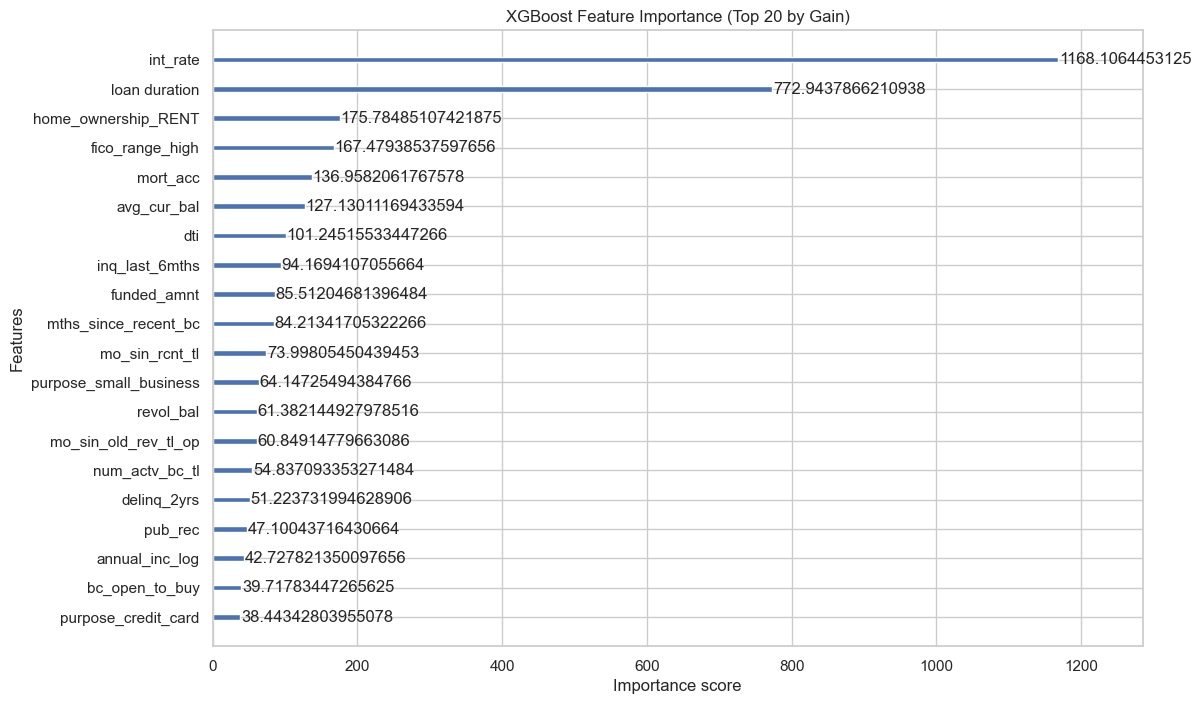


--- Top 10 Features by Gain ---
| Feature              |      Gain |
|:---------------------|----------:|
| int_rate             | 1168.11   |
| loan duration        |  772.944  |
| home_ownership_RENT  |  175.785  |
| fico_range_high      |  167.479  |
| mort_acc             |  136.958  |
| avg_cur_bal          |  127.13   |
| dti                  |  101.245  |
| inq_last_6mths       |   94.1694 |
| funded_amnt          |   85.512  |
| mths_since_recent_bc |   84.2134 |


In [216]:
# importance_type='gain' 
# Only plot max_num_features=20 
fig, ax = plt.subplots(figsize=(12, 8))

xgb.plot_importance(
    xgb_clf, 
    importance_type='gain', 
    max_num_features=20, 
    ax=ax,
    title="XGBoost Feature Importance (Top 20 by Gain)"
)
plt.show()

importance = xgb_clf.get_booster().get_score(importance_type='gain')
feature_importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Gain']
).sort_values(by='Gain', ascending=False)

print("\n--- Top 10 Features by Gain ---")
print(feature_importance_df.head(10).to_markdown(index=False))

In [217]:
baseline_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print(f"--- baseline model performance ---")
print(f"features number: {X_train.shape[1]}")
print(f"Baeline AUC: {baseline_auc:.4f}\n")



def get_feature_contribution_df(model):
    importance = model.get_booster().get_score(importance_type='gain')

    df = pd.DataFrame(
        list(importance.items()), 
        columns=['Feature', 'Gain']
    )
    total_gain = df['Gain'].sum()
    df['Contribution_Pct'] = (df['Gain'] / total_gain) * 100
    return df.sort_values(by='Contribution_Pct', ascending=True)

bottom_features_pct_df = get_feature_contribution_df(xgb_clf)

print("--- bottom features contribution (ascending) ---")
print(bottom_features_pct_df.head(10).to_markdown(index=False, floatfmt=".4f"))



--- baseline model performance ---
features number: 41
Baeline AUC: 0.7134

--- bottom features contribution (ascending) ---
| Feature                    |    Gain |   Contribution_Pct |
|:---------------------------|--------:|-------------------:|
| purpose_renewable_energy   | 18.8891 |             0.4640 |
| revol_util                 | 25.2516 |             0.6203 |
| purpose_house              | 25.7073 |             0.6314 |
| purpose_other              | 26.0676 |             0.6403 |
| tax_liens                  | 26.1296 |             0.6418 |
| num_rev_accts              | 26.6003 |             0.6534 |
| purpose_debt_consolidation | 28.0631 |             0.6893 |
| num_il_tl                  | 28.7665 |             0.7066 |
| purpose_medical            | 29.0116 |             0.7126 |
| purpose_major_purchase     | 29.4791 |             0.7241 |


In [218]:
CANDIDATE_THRESHOLD_PCT = 1.0 

features_to_drop = bottom_features_pct_df[
    bottom_features_pct_df['Contribution_Pct'] < CANDIDATE_THRESHOLD_PCT
]['Feature'].tolist()

X_train_new = X_train.drop(columns=features_to_drop, errors='ignore')
X_test_new = X_test.drop(columns=features_to_drop, errors='ignore')

print(f"new features number: {X_train_new.shape[1]}")

print("\n🔄 Retraining the simplified model...")

xgb_clf_new = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_clf_new.fit(X_train_new, y_train)

# 4: Performance Comparison

y_prob_xgb_new = xgb_clf_new.predict_proba(X_test_new)[:, 1]
new_auc = roc_auc_score(y_test, y_prob_xgb_new)
auc_change = new_auc - baseline_auc

print(f"\n--- Comparison after deletion features ---")
print(f"baseline AUC: {baseline_auc:.4f}")
print(f"new model AUC: {new_auc:.4f}")

if auc_change >= 0:
    print(f"conclusion: ✅ AUC increases/remains (+{auc_change:.4f})。succesfully deleted!！")
    print("next steps: use X_train_new and X_test_new for further optimization.")
else:
    print(f"conclusion: ❌ AUC decreases ({auc_change:.4f}). failed to delete")
    print("next steps: restore these features.try again with a stricter threshold or hyperparameter tuning.")

new features number: 18

🔄 Retraining the simplified model...

--- Comparison after deletion features ---
baseline AUC: 0.7134
new model AUC: 0.7108
conclusion: ❌ AUC decreases (-0.0026). failed to delete
next steps: restore these features.try again with a stricter threshold or hyperparameter tuning.


### 5. Finetuning Optuna

In [219]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', ratio*0.9, ratio*1.1), # 在比例附近微调

        # fix other parameters
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_jobs': -1,
        'random_state': 42
    }

    # use stratified 3-fold CV to evaluate model potential 
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in cv.split(X_train_base, y_train_base):
        X_tr, X_val = X_train_base.iloc[train_idx], X_train_base.iloc[val_idx]
        y_tr, y_val = y_train_base.iloc[train_idx], y_train_base.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr)

        # calculate AUC
        y_prob = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, y_prob))

    # return average AUC
    return np.mean(auc_scores)

# 2. hyperparameter optimization 
print("🚀 Starting Hyperparameter Optimization for Ranking Ability...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, show_progress_bar=True)

print(f"✅ Optimization Complete. Best Gini Potential: {2 * study.best_value - 1:.4f}")

# 3. retrain final model  (Champion Model)
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_jobs': -1,
    'random_state': 42
})

champion_model = xgb.XGBClassifier(**best_params)
champion_model.fit(X_train_base, y_train_base)


[I 2026-01-09 00:29:54,710] A new study created in memory with name: no-name-f2b50440-aa41-449f-9015-f4eb51884ed5


🚀 Starting Hyperparameter Optimization for Ranking Ability...


Best trial: 0. Best value: 0.706683:   7%|▋         | 1/15 [00:16<03:45, 16.14s/it]

[I 2026-01-09 00:30:10,848] Trial 0 finished with value: 0.7066829987386677 and parameters: {'n_estimators': 621, 'learning_rate': 0.010405173623903472, 'max_depth': 4, 'subsample': 0.7945822643611447, 'colsample_bytree': 0.777602207282292, 'gamma': 0.1910826679633002, 'min_child_weight': 7, 'scale_pos_weight': 3.823368785633851}. Best is trial 0 with value: 0.7066829987386677.


Best trial: 1. Best value: 0.713174:  13%|█▎        | 2/15 [00:32<03:31, 16.26s/it]

[I 2026-01-09 00:30:27,186] Trial 1 finished with value: 0.7131736032487502 and parameters: {'n_estimators': 702, 'learning_rate': 0.0752363020072733, 'max_depth': 4, 'subsample': 0.8046839002667885, 'colsample_bytree': 0.8868310523909362, 'gamma': 0.07492091891493324, 'min_child_weight': 3, 'scale_pos_weight': 4.055189808802375}. Best is trial 1 with value: 0.7131736032487502.


Best trial: 1. Best value: 0.713174:  20%|██        | 3/15 [00:39<02:23, 11.95s/it]

[I 2026-01-09 00:30:34,021] Trial 2 finished with value: 0.7106665945354868 and parameters: {'n_estimators': 337, 'learning_rate': 0.07757812938861074, 'max_depth': 3, 'subsample': 0.7323457490232969, 'colsample_bytree': 0.871978039692145, 'gamma': 0.17319150361339342, 'min_child_weight': 3, 'scale_pos_weight': 4.044669355476112}. Best is trial 1 with value: 0.7131736032487502.


Best trial: 1. Best value: 0.713174:  27%|██▋       | 4/15 [00:54<02:24, 13.15s/it]

[I 2026-01-09 00:30:48,996] Trial 3 finished with value: 0.7129632369911613 and parameters: {'n_estimators': 581, 'learning_rate': 0.06369077066187843, 'max_depth': 4, 'subsample': 0.892606461625431, 'colsample_bytree': 0.7510940740597358, 'gamma': 0.021342567552993796, 'min_child_weight': 5, 'scale_pos_weight': 3.595590900970833}. Best is trial 1 with value: 0.7131736032487502.


Best trial: 1. Best value: 0.713174:  33%|███▎      | 5/15 [01:19<02:56, 17.66s/it]

[I 2026-01-09 00:31:14,646] Trial 4 finished with value: 0.7128903307413571 and parameters: {'n_estimators': 757, 'learning_rate': 0.023093294503470314, 'max_depth': 6, 'subsample': 0.7814825893276373, 'colsample_bytree': 0.8932169959090478, 'gamma': 0.0008642184063940795, 'min_child_weight': 5, 'scale_pos_weight': 3.9771931933448963}. Best is trial 1 with value: 0.7131736032487502.


Best trial: 1. Best value: 0.713174:  40%|████      | 6/15 [01:31<02:20, 15.58s/it]

[I 2026-01-09 00:31:26,192] Trial 5 finished with value: 0.7115105708188666 and parameters: {'n_estimators': 326, 'learning_rate': 0.04396250454312751, 'max_depth': 5, 'subsample': 0.7894415571624275, 'colsample_bytree': 0.8582182318180893, 'gamma': 0.1043499227368306, 'min_child_weight': 4, 'scale_pos_weight': 3.7373352319836384}. Best is trial 1 with value: 0.7131736032487502.


Best trial: 1. Best value: 0.713174:  47%|████▋     | 7/15 [01:42<01:52, 14.05s/it]

[I 2026-01-09 00:31:37,100] Trial 6 finished with value: 0.7061079948968576 and parameters: {'n_estimators': 238, 'learning_rate': 0.013924784065660487, 'max_depth': 6, 'subsample': 0.7610830065306172, 'colsample_bytree': 0.7622388053582593, 'gamma': 0.19123645344525836, 'min_child_weight': 2, 'scale_pos_weight': 4.111193058019179}. Best is trial 1 with value: 0.7131736032487502.


Best trial: 1. Best value: 0.713174:  53%|█████▎    | 8/15 [01:56<01:37, 13.91s/it]

[I 2026-01-09 00:31:50,719] Trial 7 finished with value: 0.711349884140157 and parameters: {'n_estimators': 592, 'learning_rate': 0.053157986710590875, 'max_depth': 3, 'subsample': 0.7818816699296887, 'colsample_bytree': 0.8402509836707119, 'gamma': 0.15800750429470647, 'min_child_weight': 7, 'scale_pos_weight': 3.73119996234472}. Best is trial 1 with value: 0.7131736032487502.


Best trial: 8. Best value: 0.713328:  60%|██████    | 9/15 [02:17<01:38, 16.40s/it]

[I 2026-01-09 00:32:12,574] Trial 8 finished with value: 0.7133275874670684 and parameters: {'n_estimators': 750, 'learning_rate': 0.05468202690832371, 'max_depth': 5, 'subsample': 0.7710632093932642, 'colsample_bytree': 0.8999035483010198, 'gamma': 0.015182838834918222, 'min_child_weight': 1, 'scale_pos_weight': 3.4920481189311414}. Best is trial 8 with value: 0.7133275874670684.


Best trial: 8. Best value: 0.713328:  67%|██████▋   | 10/15 [02:28<01:13, 14.73s/it]

[I 2026-01-09 00:32:23,568] Trial 9 finished with value: 0.7073771026259005 and parameters: {'n_estimators': 541, 'learning_rate': 0.022014817201875054, 'max_depth': 3, 'subsample': 0.8997275037572631, 'colsample_bytree': 0.7431415942191647, 'gamma': 0.1771872049520391, 'min_child_weight': 7, 'scale_pos_weight': 3.9021394145923374}. Best is trial 8 with value: 0.7133275874670684.


Best trial: 8. Best value: 0.713328:  73%|███████▎  | 11/15 [02:52<01:10, 17.58s/it]

[I 2026-01-09 00:32:47,598] Trial 10 finished with value: 0.7131462005953789 and parameters: {'n_estimators': 794, 'learning_rate': 0.031037394528521597, 'max_depth': 5, 'subsample': 0.8416103913571479, 'colsample_bytree': 0.7019066680304543, 'gamma': 0.055879229926209965, 'min_child_weight': 1, 'scale_pos_weight': 3.4437646269459954}. Best is trial 8 with value: 0.7133275874670684.


Best trial: 8. Best value: 0.713328:  80%|████████  | 12/15 [03:12<00:54, 18.24s/it]

[I 2026-01-09 00:33:07,345] Trial 11 finished with value: 0.7121582717636956 and parameters: {'n_estimators': 704, 'learning_rate': 0.09642315428897788, 'max_depth': 5, 'subsample': 0.8352499125214224, 'colsample_bytree': 0.8230751865522038, 'gamma': 0.07637977997011805, 'min_child_weight': 1, 'scale_pos_weight': 4.166027320502161}. Best is trial 8 with value: 0.7133275874670684.


Best trial: 8. Best value: 0.713328:  87%|████████▋ | 13/15 [03:30<00:36, 18.12s/it]

[I 2026-01-09 00:33:25,199] Trial 12 finished with value: 0.7125302066661693 and parameters: {'n_estimators': 679, 'learning_rate': 0.04049368352255285, 'max_depth': 4, 'subsample': 0.7153417903532135, 'colsample_bytree': 0.8927883503097475, 'gamma': 0.1158017547906299, 'min_child_weight': 3, 'scale_pos_weight': 3.476333708491219}. Best is trial 8 with value: 0.7133275874670684.


Best trial: 8. Best value: 0.713328:  93%|█████████▎| 14/15 [03:44<00:16, 16.83s/it]

[I 2026-01-09 00:33:39,040] Trial 13 finished with value: 0.7129866337948366 and parameters: {'n_estimators': 451, 'learning_rate': 0.07418418761777014, 'max_depth': 5, 'subsample': 0.8325621300410624, 'colsample_bytree': 0.8047205861276864, 'gamma': 0.04441844018420228, 'min_child_weight': 2, 'scale_pos_weight': 3.589029204670562}. Best is trial 8 with value: 0.7133275874670684.


Best trial: 8. Best value: 0.713328: 100%|██████████| 15/15 [04:03<00:00, 16.22s/it]


[I 2026-01-09 00:33:57,943] Trial 14 finished with value: 0.7130579376219135 and parameters: {'n_estimators': 691, 'learning_rate': 0.09081970469385435, 'max_depth': 4, 'subsample': 0.747514710199978, 'colsample_bytree': 0.8607513367504481, 'gamma': 0.08006205228768695, 'min_child_weight': 2, 'scale_pos_weight': 3.9369145188636607}. Best is trial 8 with value: 0.7133275874670684.
✅ Optimization Complete. Best Gini Potential: 0.4267


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8999035483010198
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [220]:
y_prob_raw = champion_model.predict_proba(X_test)[:, 1]

# key metrics
final_auc = roc_auc_score(y_test, y_prob_raw)
final_gini = 2 * final_auc - 1
avg_precision = average_precision_score(y_test, y_prob_raw) # PR-AUC
test_logloss = log_loss(y_test, y_prob_raw)
test_brier = brier_score_loss(y_test, y_prob_raw) 

print("\n" + "="*50)
print("🏁 CHAMPION MODEL COMPLETE ASSESSMENT (PRE-CALIBRATION)")
print("="*50)

print(f"\n[1. Ranking Ability (Core)]")
print(f"| ROC-AUC Score:      | {final_auc:.4f} |")
print(f"| Gini Coefficient:   | {final_gini:.4f} |")
print(f"| PR-AUC (Avg Prec):  | {avg_precision:.4f} | (More robust for imbalanced data)")

print(f"\n[2. Probabilistic Quality (Pre-calibration)]")
print(f"| Log Loss:           | {test_logloss:.4f} |")
print(f"| Brier Score:        | {test_brier:.4f} | (Closer to 0 indicates better probability accuracy)")

print("💡 Note: Precision/Recall values here are based on a 0.5 threshold for reference only.")
print("   These metrics will change significantly after finding the optimal threshold post-calibration.")


🏁 CHAMPION MODEL COMPLETE ASSESSMENT (PRE-CALIBRATION)

[1. Ranking Ability (Core)]
| ROC-AUC Score:      | 0.7161 |
| Gini Coefficient:   | 0.4322 |
| PR-AUC (Avg Prec):  | 0.4558 | (More robust for imbalanced data)

[2. Probabilistic Quality (Pre-calibration)]
| Log Loss:           | 0.5911 |
| Brier Score:        | 0.2040 | (Closer to 0 indicates better probability accuracy)
💡 Note: Precision/Recall values here are based on a 0.5 threshold for reference only.
   These metrics will change significantly after finding the optimal threshold post-calibration.


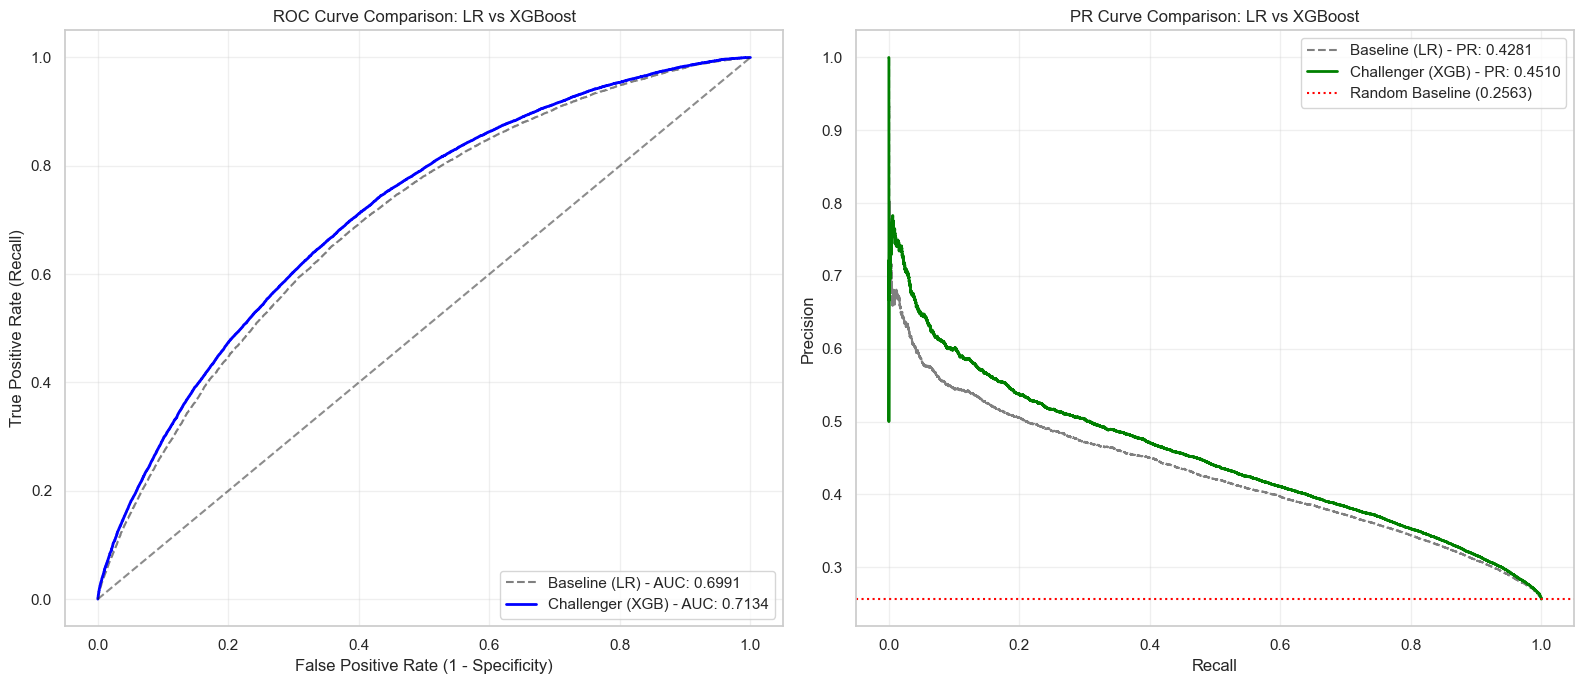

📈 Gini Improvement: 0.3982 -> 0.4269 (7.21% improvement)


In [221]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# --- A. ROC ---
# Baseline (Logistic Regression)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

# Challenger model (XGBoost)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# --- B. PR ---
# Baseline (Logistic Regression)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_prob_lr)
pr_auc_lr = average_precision_score(y_test, y_prob_lr)

# Challenger model (XGBoost)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
pr_auc_xgb = average_precision_score(y_test, y_prob_xgb)

plt.figure(figsize=(16, 7))

# 1. ROC comparison plot
plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f'Baseline (LR) - AUC: {auc_lr:.4f}', color='gray', linestyle='--')
plt.plot(fpr_xgb, tpr_xgb, label=f'Challenger (XGB) - AUC: {auc_xgb:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5) # 随机猜测线
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison: LR vs XGBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# 2. PR comparison plot 
plt.subplot(1, 2, 2)
plt.plot(rec_lr, prec_lr, label=f'Baseline (LR) - PR: {pr_auc_lr:.4f}', color='gray', linestyle='--')
plt.plot(rec_xgb, prec_xgb, label=f'Challenger (XGB) - PR: {pr_auc_xgb:.4f}', color='green', lw=2)
# compute random baseline
baseline = y_test.sum() / len(y_test)
plt.axhline(y=baseline, color='red', linestyle=':', label=f'Random Baseline ({baseline:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve Comparison: LR vs XGBoost')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Gini Improvement calculation 
gini_lr = 2 * auc_lr - 1
gini_xgb = 2 * auc_xgb - 1
improvement = (gini_xgb - gini_lr) / gini_lr * 100
print(f"📈 Gini Improvement: {gini_lr:.4f} -> {gini_xgb:.4f} ({improvement:.2f}% improvement)")

L'axe X représente le taux de faux positifs (le coût : les bons clients qu'on refuse à tort).

L'axe Y représente le taux de vrais positifs (le gain : les défauts qu'on détecte correctement).

On voit que la courbe bleue (XGBoost) est constamment au-dessus de la grise. Avec un AUC de 0.713 contre 0.699, XGBoost a un meilleur pouvoir discriminant global. Il nous permet de détecter plus de fraudeurs pour un même taux d'erreur.


### 6. Calibration using Isotonic  Regression

/Users/kaixinxie/Credit_Risk_forCapgemini/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


🧪 Step 3: Evaluating on OOT Test set...


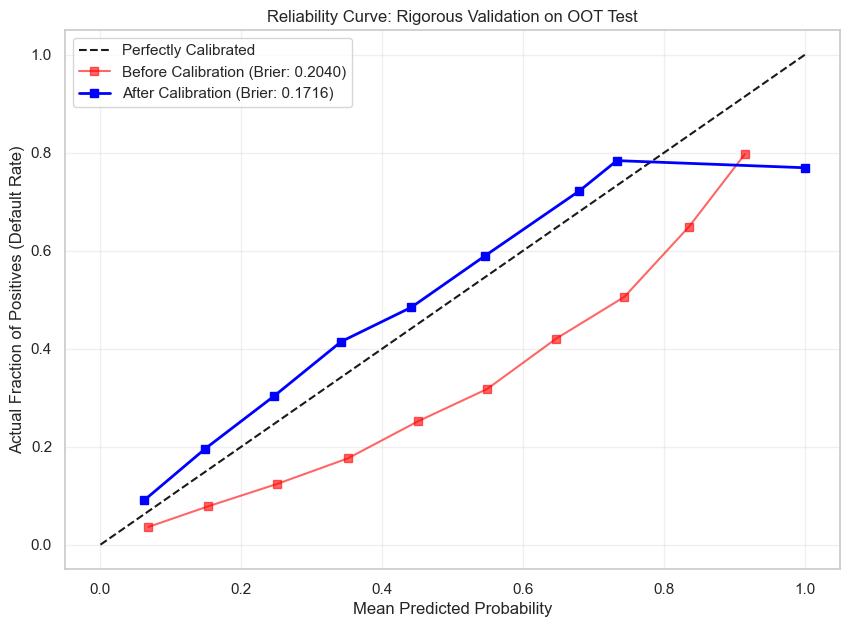

------------------------------
✅ Gini Check (Before): 0.4322
✅ Gini Check (After):  0.4320
✅ Brier Improvement:  0.2040 -> 0.1716
------------------------------


In [222]:
calibrator = CalibratedClassifierCV(champion_model, cv='prefit', method='isotonic')
calibrator.fit(X_val_cal, y_val_cal)

# 3. on X_test / OOT
print("🧪 Step 3: Evaluating on OOT Test set...")
y_prob_raw = champion_model.predict_proba(X_test)[:, 1]
y_prob_calibrated = calibrator.predict_proba(X_test)[:, 1]

# 4. Brier Score (越小越好)
brier_before = brier_score_loss(y_test, y_prob_raw)
brier_after = brier_score_loss(y_test, y_prob_calibrated)

# 5. Reliability Curve)
prob_true_raw, prob_pred_raw = calibration_curve(y_test, y_prob_raw, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_calibrated, n_bins=10)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
# Before
plt.plot(prob_pred_raw, prob_true_raw, 's-', color='red', alpha=0.6,
         label=f'Before Calibration (Brier: {brier_before:.4f})')
# After
plt.plot(prob_pred_cal, prob_true_cal, 's-', color='blue', lw=2,
         label=f'After Calibration (Brier: {brier_after:.4f})')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Actual Fraction of Positives (Default Rate)')
plt.title('Reliability Curve: Rigorous Validation on OOT Test')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

# 7. Final Check
print("-" * 30)
print(f"✅ Gini Check (Before): {2 * roc_auc_score(y_test, y_prob_raw) - 1:.4f}")
print(f"✅ Gini Check (After):  {2 * roc_auc_score(y_test, y_prob_calibrated) - 1:.4f}")
print(f"✅ Brier Improvement:  {brier_before:.4f} -> {brier_after:.4f}")
print("-" * 30)

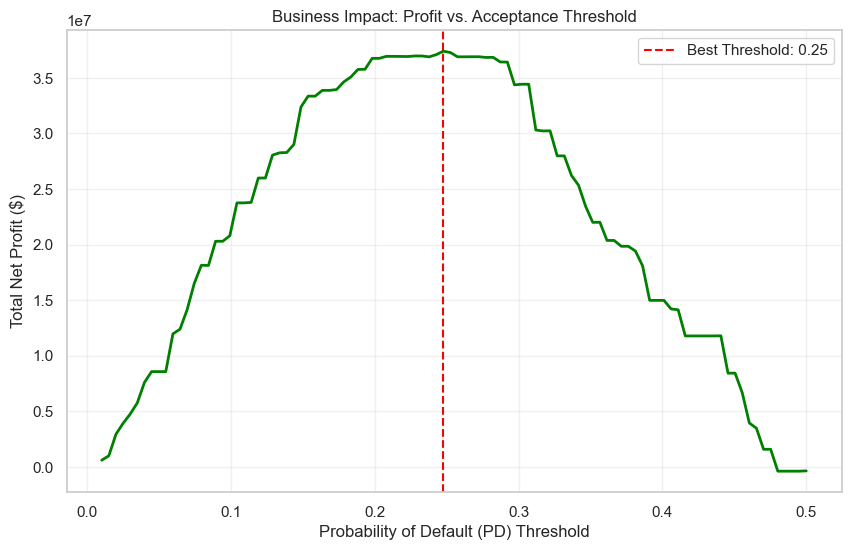

💰 Under the Calibrated Model:
✅ Optimal PD Threshold (Red Line): 0.25
✅ Expected Total Profit under this strategy: $37,395,494.74

📊 Comparison: If using 0.5 threshold blindly, profit is only: $-368,840.62
📈 Optimized threshold helped you earn an extra: $37,764,335.35


In [229]:
# 1. Prepare Financial Data (Assuming test_financials.csv is already loaded)
# Ensure the order of test_financials matches y_test
# financials = pd.read_csv('../data/processed/test_financials.csv')

# 2. Define Profit Calculation Function
def calculate_profit(y_true, y_prob, threshold, financials):
    # Determine whether to lend based on threshold (Predicting 0 means grant loan)
    will_lend = y_prob <= threshold
    
    principal = financials['funded_amnt'].values
    rate = financials['int_rate'].values / 100  # 假设原始数据是 13.5
    
    # 3. 解析期限 (Duration)
    # 根据 Data Description: 0 -> 36个月(3年), 1 -> 60个月(5年)
    # 我们创建一个 duration_years 数组
    duration_val = financials['loan duration'].values
    duration_years = np.where(duration_val == 0, 3.0, 5.0)
    
    # 4. 计算好人的“全生命周期总利润” (Total Lifetime Value)
    # 粗略估算：本金 * 年利率 * 年数 * 0.6 (摊销系数，因为本金越还越少)
    # 比如 10000 * 0.13 * 3 * 0.6 = 2340 (这比只算1年 1300 要多多了)
    profit_success = principal * rate * duration_years * 0.6
    
    # 5. 计算坏人的损失
    # 假设坏账通常发生在第 1 年，本金损失 80% (假设还能追回 20%)
    loss_default = -principal * 0.8
    
    # 6. 汇总
    final_pnl = np.zeros_like(y_true, dtype=float)
    mask_lend = will_lend
    
    # 赚的情况
    final_pnl[mask_lend & (y_true == 0)] = profit_success[mask_lend & (y_true == 0)]
    # 亏的情况
    final_pnl[mask_lend & (y_true == 1)] = loss_default[mask_lend & (y_true == 1)]
    
    return np.sum(final_pnl)

# 3. Iterate through thresholds to find the optimal solution
thresholds = np.linspace(0.01, 0.50, 100)
profits = [calculate_profit(y_test.values, y_prob_calibrated, t, test_financials) for t in thresholds]

best_idx = np.argmax(profits)
best_threshold = thresholds[best_idx]
max_profit = profits[best_idx]

# 4. Plotting: Profit vs. Threshold Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('Business Impact: Profit vs. Acceptance Threshold')
plt.xlabel('Probability of Default (PD) Threshold')
plt.ylabel('Total Net Profit ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"💰 Under the Calibrated Model:")
print(f"✅ Optimal PD Threshold (Red Line): {best_threshold:.2f}")
print(f"✅ Expected Total Profit under this strategy: ${max_profit:,.2f}")

# 5. Compare with 0.5 Threshold
profit_05 = calculate_profit(y_test.values, y_prob_calibrated, 0.5, test_financials)
print(f"\n📊 Comparison: If using 0.5 threshold blindly, profit is only: ${profit_05:,.2f}")
print(f"📈 Optimized threshold helped you earn an extra: ${max_profit - profit_05:,.2f}")

Ce script ne se contente pas de prédire les défauts, il effectue une optimisation du profit (Profit Maximization).

En crédit, la matrice de coûts est asymétrique :

Un Faux Négatif (prêter à un fraudeur) coûte très cher : on perd tout le capital (Principal Loss).

Un Faux Positif (refuser un bon client) coûte moins cher : on perd seulement les intérêts (Opportunity Cost).

Par conséquent, utiliser le seuil par défaut de 0.5 n'est pas optimal. J'ai écrit une fonction pour simuler le P&L (Profit and Loss) à différents seuils. Le graphique me permet de trouver le seuil de rentabilité maximale (Optimal Threshold), qui est souvent bien inférieur à 0.5 (par exemple 0.15), afin de protéger le capital de la banque.

📊 DIAGNOSTIC: Predicted Probability Distribution
Mean:  0.2090
Std:   0.1376
Min:   0.0000
Max:   1.0000
Median: 0.1821

Distribution by buckets:
  < 0.1:  24813 ( 26.1%)
0.1-0.2: 26738 ( 28.2%)
0.2-0.3: 21005 ( 22.1%)
0.3-0.4: 12416 ( 13.1%)
  > 0.4:   9921 ( 10.5%)

💰 DIAGNOSTIC: Acceptance Rate Analysis
Acceptance rate at PD=0.25: 66.9%
Acceptance rate at PD=0.50: 96.1%

📈 DIAGNOSTIC: Performance at Optimal Threshold (0.25)
True Negatives (Accept & Non-Default): 52609
False Negatives (Accept & Default):    10861 ⚠️ 损失
False Positives (Reject & Non-Default): 17963 ⚠️ 机会成本

Actual default rate in test set: 25.6%


/var/folders/5s/lfpnb79x1k35l8xqh6lj3t0r0000gn/T/ipykernel_31195/2578772316.py:71: UserWarning: Glyph 25490 (\N{CJK UNIFIED IDEOGRAPH-6392}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5s/lfpnb79x1k35l8xqh6lj3t0r0000gn/T/ipykernel_31195/2578772316.py:71: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5s/lfpnb79x1k35l8xqh6lj3t0r0000gn/T/ipykernel_31195/2578772316.py:71: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5s/lfpnb79x1k35l8xqh6lj3t0r0000gn/T/ipykernel_31195/2578772316.py:71: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5s/lfpnb79x1k35l8xqh6lj3t0r0000gn/T/ipykernel_31195/2578772316.py:71: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/5s/lfpnb79x1k35l8xqh6lj3t0r0000gn/T/i

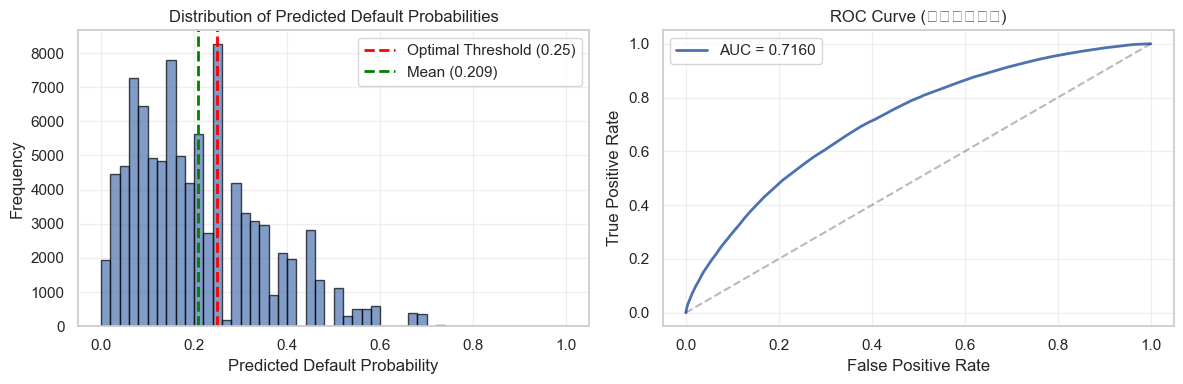

In [232]:
import matplotlib.pyplot as plt

# 诊断1：预测概率分布
print("="*50)
print("📊 DIAGNOSTIC: Predicted Probability Distribution")
print("="*50)
print(f"Mean:  {y_prob_calibrated.mean():.4f}")
print(f"Std:   {y_prob_calibrated.std():.4f}")
print(f"Min:   {y_prob_calibrated.min():.4f}")
print(f"Max:   {y_prob_calibrated.max():.4f}")
print(f"Median: {np.median(y_prob_calibrated):.4f}")

print("\nDistribution by buckets:")
print(f"  < 0.1:  {(y_prob_calibrated < 0.1).sum():5d} ({(y_prob_calibrated < 0.1).sum()/len(y_prob_calibrated)*100:5.1f}%)")
print(f"0.1-0.2: {((y_prob_calibrated >= 0.1) & (y_prob_calibrated < 0.2)).sum():5d} ({((y_prob_calibrated >= 0.1) & (y_prob_calibrated < 0.2)).sum()/len(y_prob_calibrated)*100:5.1f}%)")
print(f"0.2-0.3: {((y_prob_calibrated >= 0.2) & (y_prob_calibrated < 0.3)).sum():5d} ({((y_prob_calibrated >= 0.2) & (y_prob_calibrated < 0.3)).sum()/len(y_prob_calibrated)*100:5.1f}%)")
print(f"0.3-0.4: {((y_prob_calibrated >= 0.3) & (y_prob_calibrated < 0.4)).sum():5d} ({((y_prob_calibrated >= 0.3) & (y_prob_calibrated < 0.4)).sum()/len(y_prob_calibrated)*100:5.1f}%)")
print(f"  > 0.4:  {(y_prob_calibrated > 0.4).sum():5d} ({(y_prob_calibrated > 0.4).sum()/len(y_prob_calibrated)*100:5.1f}%)")

# 诊断2：在最优阈值下的接受率
print("\n" + "="*50)
print("💰 DIAGNOSTIC: Acceptance Rate Analysis")
print("="*50)
acceptance_025 = (y_prob_calibrated <= 0.25).sum() / len(y_prob_calibrated)
acceptance_05 = (y_prob_calibrated <= 0.5).sum() / len(y_prob_calibrated)
print(f"Acceptance rate at PD=0.25: {acceptance_025*100:.1f}%")
print(f"Acceptance rate at PD=0.50: {acceptance_05*100:.1f}%")

# 诊断3：在最优阈值下的实际表现
y_pred_025 = (y_prob_calibrated <= 0.25).astype(int)  # 1 = accept, 0 = reject
print("\n" + "="*50)
print("📈 DIAGNOSTIC: Performance at Optimal Threshold (0.25)")
print("="*50)
tn = ((y_pred_025 == 1) & (y_test == 0)).sum()  # 赞同且非违约
fn = ((y_pred_025 == 1) & (y_test == 1)).sum()  # 赞同但违约
fp = ((y_pred_025 == 0) & (y_test == 0)).sum()  # 拒绝但非违约
print(f"True Negatives (Accept & Non-Default): {tn}")
print(f"False Negatives (Accept & Default):    {fn} ⚠️ 损失")
print(f"False Positives (Reject & Non-Default): {fp} ⚠️ 机会成本")

# 实际违约率分析
default_rate = (y_test == 1).sum() / len(y_test)
print(f"\nActual default rate in test set: {default_rate*100:.1f}%")

# 直方图
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y_prob_calibrated, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(0.25, color='red', linestyle='--', lw=2, label='Optimal Threshold (0.25)')
plt.axvline(y_prob_calibrated.mean(), color='green', linestyle='--', lw=2, label=f'Mean ({y_prob_calibrated.mean():.3f})')
plt.xlabel('Predicted Default Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Default Probabilities')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# ROC曲线，看排序能力
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_calibrated)
auc_val = roc_auc_score(y_test, y_prob_calibrated)
plt.plot(fpr, tpr, lw=2, label=f'AUC = {auc_val:.4f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (排序能力评估)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [234]:
base_path = '/Users/kaixinxie/Credit_Risk_forCapgemini/models'
os.makedirs(base_path, exist_ok=True) # 如果文件夹不存在则创建

model_path = os.path.join(base_path, 'champion_model.joblib')
features_path = os.path.join(base_path, 'model_features.joblib')
calibrator_path = os.path.join(base_path, 'calibrator.joblib') # 建议也保存校准器

model_features = X_train_base.columns.tolist()


joblib.dump(champion_model, model_path)
print(f"\n✅ CHAMPION MODEL saved successfully to: {model_path}")
joblib.dump(model_features, features_path)
print(f"✅ FEATURE LIST saved successfully to: {features_path}")
joblib.dump(calibrator, calibrator_path)
print(f"✅ CALIBRATOR saved successfully to: {calibrator_path}")

print("\n🎉 All model components are secured and ready for deployment!")


✅ CHAMPION MODEL saved successfully to: /Users/kaixinxie/Credit_Risk_forCapgemini/models/champion_model.joblib
✅ FEATURE LIST saved successfully to: /Users/kaixinxie/Credit_Risk_forCapgemini/models/model_features.joblib
✅ CALIBRATOR saved successfully to: /Users/kaixinxie/Credit_Risk_forCapgemini/models/calibrator.joblib

🎉 All model components are secured and ready for deployment!


📊 Generating XGBoost Built-in Feature Importance (Gain)...


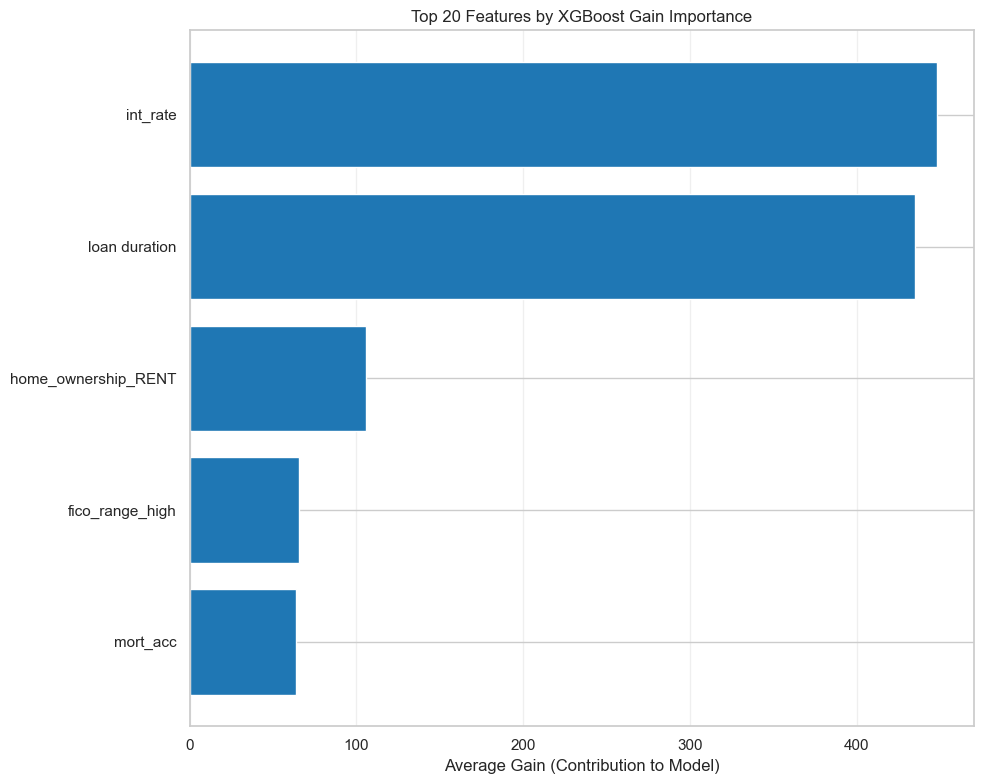


🧠 Generating SHAP Summary Plot (State-of-the-Art Interpretability)...
⏳ 计算 SHAP 值可能需要几分钟，请耐心等待...


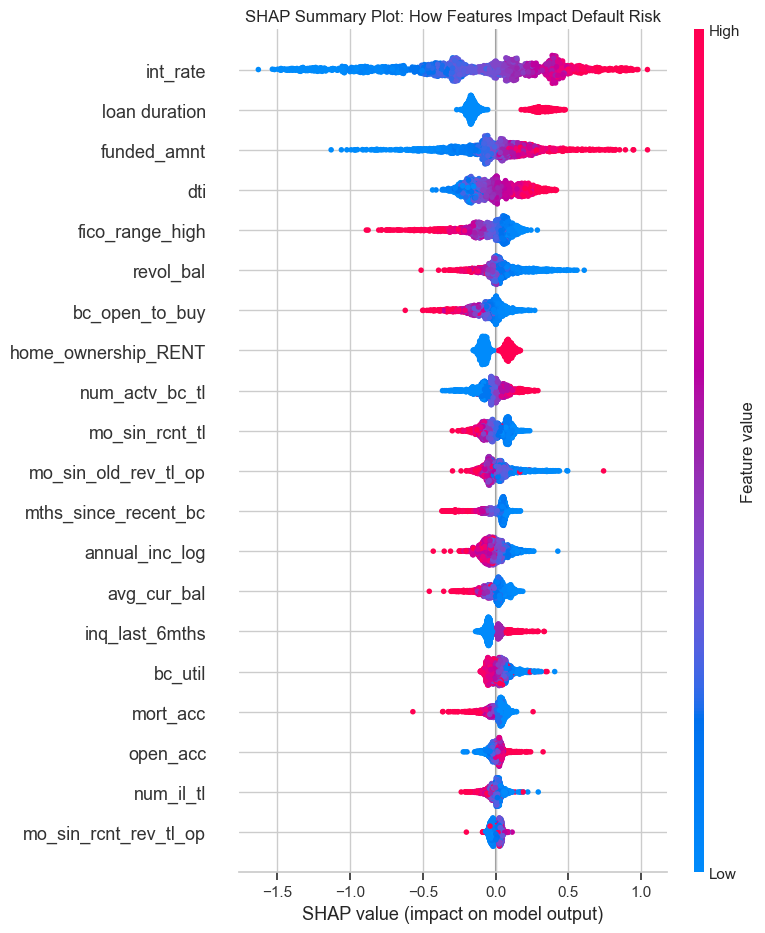

In [ ]:

# =========================================
# 方法 A：XGBoost 内置特征重要性 (基于 Gain)
# =========================================
print("📊 Generating XGBoost Built-in Feature Importance (Gain)...")

# 获取特征重要性字典
importance_dict = champion_model.get_booster().get_score(importance_type='gain')

# 转换为 DataFrame 并排序
feat_imp = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Gain'])
feat_imp = feat_imp.sort_values(by='Gain', ascending=False).head(5) # 只看前5个

# 绘图
plt.figure(figsize=(10, 8))
plt.barh(feat_imp['Feature'][::-1], feat_imp['Gain'][::-1], color='#1f77b4')
plt.xlabel('Average Gain (Contribution to Model)')
plt.title('Top 20 Features by XGBoost Gain Importance')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# =========================================
# 方法 B：SHAP 值分析 (行业金标准 - 可解释性 AI)
# =========================================
print("\n🧠 Generating SHAP Summary Plot (State-of-the-Art Interpretability)...")
print("⏳ 计算 SHAP 值可能需要几分钟，请耐心等待...")

# 1. 创建解释器
# TreeExplainer 专用于树模型，速度快
explainer = shap.TreeExplainer(champion_model)

# 2. 计算 SHAP 值
# 为了速度，我们从测试集中随机抽取 2000 个样本进行分析（足够代表整体）
X_test_sample = X_test.sample(n=2000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# 3. 绘制蜂群图 (Beeswarm Plot)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False)
plt.title('SHAP Summary Plot: How Features Impact Default Risk')
plt.tight_layout()
plt.show()

Ce graphique est un SHAP Summary Plot. C'est l'outil le plus puissant pour l'interprétabilité globale (Global Interpretability). Il combine deux informations cruciales : l'importance des variables (classement vertical) et la direction de leur impact (axe horizontal)."

2. 解读最显著的特征：利率 (Le facteur principal : int_rate)
"Premièrement, on voit que int_rate (le taux d'intérêt) est la variable la plus déterminante. La distribution des couleurs est très claire : les points rouges (taux élevés) sont situés à l'extrême droite. Cela signifie qu'un taux d'intérêt élevé augmente fortement la probabilité de défaut, ce qui est tout à fait cohérent avec la logique financière."

3. 解读反向指标：信用分 (La relation inverse : FICO Score)
"Deuxièmement, il est très rassurant d'observer le comportement du fico_range_high (le score de crédit). Contrairement au taux d'intérêt, ici les points rouges (scores élevés) sont concentrés sur la gauche (valeurs SHAP négatives). Cela prouve que le modèle a correctement appris la relation inverse : plus le score de crédit est bon, plus le risque diminue. C'est un excellent signe de robustesse."